***Viewers are warned that this notebook contains content that is offensive and objectionable***

This notebook has the main purpose to make a call to my local MySQL database and import all the tweets that have been collected from the Twitter API in the last 300 minutes.

After that, these fresh tweets go exactly through the same process that all the tweets for the training of the model have also gone through.

Attaching below all the steps mimicking the previous pre-processing for the offline 40000 tweets:

- Lemmatization with part-of-speech
- Removal of stopwords and words shorter than 3 characters
- Lowering of all words 
- tf-idf vectorization using the pickled fitted matrix made out of the 9000 most important words

At this point, the final winning model is recalled and predictions are made on the newly collected tweets.

Threshold selection is applied only at this stage whereby we are telling the model to deem as offensive only tweets with 90%+ chance of being offensive. This has been done because the whole model is based purely on tf-idf guesses and context is not something this algorithm really deals well with. Selecting such a high threshold will ensure that only messages with very strong content get deemed as offensive. Building a model better at picking up the nuances of context is something that can be achieved with a RNN model or by using pre-trained word embeddings such as word2vec and Glove. This is some of the areas this projects can be improved on. 

Tweets are called from the local MySQL every 4 hours and a new csv with all the fresh tweets is sent to another git repo responsible for the final processing and uploading of updated findings onto Heroku.

    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import seaborn as sns
import re
import nltk
import pickle
from joblib import dump, load
from datetime import date

import os
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# function to make n-grams
from nltk.util import ngrams 
from nltk import everygrams
import streamlit as st

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore') 
# %matplotlib inline

# connection to the MySQL local database
import mysql.connector

# importing cusstom functions
from functions.custom_function_5 import tokenize_tweet
from functions.custom_function_5 import get_tokens_frequency_df
from functions.custom_function_5 import plot_word_cloud
from functions.custom_function_5 import clean_text
from functions.custom_function_5 import lemmatize_sentence

In [16]:
# increasing max length for all columns and number of columns
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_columns", 50)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In the next cell, a connection with the local databse where all the fresh Tweets are stored is established.

In [17]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="password",
    database="twitter_2",
    charset = 'utf8'
 )


In [18]:
# check that it's connected
mycursor = db.cursor()
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)
    

('twitter_2',)


Here the present time and the delta of 300 minutes is created so that only Tweets from the last 300 minutes are pulled in the dataframe.

In [19]:
time_now = datetime.now()
time_now.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-26 12:07:46'

In [23]:
time_300mins_before = timedelta(hours=0,minutes=200)
time_300mins_before

datetime.timedelta(seconds=12000)

In [24]:
time_interval = time_now - time_300mins_before
time_interval.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-26 08:47:46'

In [25]:
# load data in the last 1 hour
query = "SELECT id_str, created_at, text, processed FROM twitter_2 WHERE created_at >= '{}'"     \
        .format(time_interval)

df = pd.read_sql(query, con=db)

In [26]:
# UTC for date time at default
df['created_at'] = pd.to_datetime(df['created_at'])

In [27]:
df.head(5)

,id_str,created_at,text,processed
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic. https://t.co/GMkpSOMkhk,-1
1,1265237759821844486,2020-05-26 11:06:03,RT @KOKO_TV: Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID-19 Cases. https://t.co/IeqD1u4luU #StopCovidLies,-1
2,1265237761038192641,2020-05-26 11:06:03,RT @FACLTD: Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1
3,1265237762531262466,2020-05-26 11:06:04,RT @McauleyHolmes: Staten Islanders with masks drive out non-mask wearing person in grocery store. #Coronavirus https://t.co/iPQwk7lD9y,-1
4,1265237762543763457,2020-05-26 11:06:04,RT @cryborg: Idk about you?\nDid we go to all this trouble (to stop the spread of #coronavirus) just to turn around and let these brainwashe,-1


In [28]:
len(df)

176

A separate function has been created so that all the preproccesing steps are also applied to the fresh Tweets.

In [29]:
df['text'] = df['text'].apply(clean_text)

In [30]:
# also getting rid of all words shorter than 3 characters
df['tweet_more_2_charac'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

In [31]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic,-1,#Tokyo started new normal way life Tuesday after lifting its health alert for the #coronavirus pandemic
1,1265237759821844486,2020-05-26 11:06:03,RT Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID Cases #StopCovidLies,-1,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases #StopCovidLies
2,1265237761038192641,2020-05-26 11:06:03,RT Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1,Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring part lockdown releas
3,1265237762531262466,2020-05-26 11:06:04,RT Staten Islanders with masks drive out non mask wearing person in grocery store #Coronavirus,-1,Staten Islanders with masks drive out non mask wearing person grocery store #Coronavirus
4,1265237762543763457,2020-05-26 11:06:04,RT Idk about you Did we go to all this trouble to stop the spread of #coronavirus just to turn around and let these brainwashe,-1,Idk about you Did all this trouble stop the spread #coronavirus just turn around and let these brainwashe



# Lemmatization with POS

Applying lemmatization exaclty in the same way it has been done for the original dataset.

In [32]:
df['lemmatized'] = df['tweet_more_2_charac'].apply(lambda x: lemmatize_sentence(x))

In [33]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic,-1,#Tokyo started new normal way life Tuesday after lifting its health alert for the #coronavirus pandemic,# Tokyo start new normal way life Tuesday after lift its health alert for the # coronavirus pandemic
1,1265237759821844486,2020-05-26 11:06:03,RT Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID Cases #StopCovidLies,-1,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases #StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases # StopCovidLies
2,1265237761038192641,2020-05-26 11:06:03,RT Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1,Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas
3,1265237762531262466,2020-05-26 11:06:04,RT Staten Islanders with masks drive out non mask wearing person in grocery store #Coronavirus,-1,Staten Islanders with masks drive out non mask wearing person grocery store #Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store # Coronavirus
4,1265237762543763457,2020-05-26 11:06:04,RT Idk about you Did we go to all this trouble to stop the spread of #coronavirus just to turn around and let these brainwashe,-1,Idk about you Did all this trouble stop the spread #coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread # coronavirus just turn around and let these brainwashe


In [34]:
# getting rid of the ashtags
df['lemmatized_no_ash'] = df['lemmatized'].str.replace('# ', '')

In [35]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic,-1,#Tokyo started new normal way life Tuesday after lifting its health alert for the #coronavirus pandemic,# Tokyo start new normal way life Tuesday after lift its health alert for the # coronavirus pandemic,Tokyo start new normal way life Tuesday after lift its health alert for the coronavirus pandemic
1,1265237759821844486,2020-05-26 11:06:03,RT Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID Cases #StopCovidLies,-1,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases #StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases # StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases StopCovidLies
2,1265237761038192641,2020-05-26 11:06:03,RT Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1,Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas
3,1265237762531262466,2020-05-26 11:06:04,RT Staten Islanders with masks drive out non mask wearing person in grocery store #Coronavirus,-1,Staten Islanders with masks drive out non mask wearing person grocery store #Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store # Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store Coronavirus
4,1265237762543763457,2020-05-26 11:06:04,RT Idk about you Did we go to all this trouble to stop the spread of #coronavirus just to turn around and let these brainwashe,-1,Idk about you Did all this trouble stop the spread #coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread # coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread coronavirus just turn around and let these brainwashe


Removing StopWords

In [36]:
# importing english stopwords
stop = stopwords.words('english')

df['tweet_low'] = df['lemmatized_no_ash'].apply(lambda x: x if type(x)!=str else x.lower())
df['tweet_without_stopwords'] = df['tweet_low'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



In [37]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic,-1,#Tokyo started new normal way life Tuesday after lifting its health alert for the #coronavirus pandemic,# Tokyo start new normal way life Tuesday after lift its health alert for the # coronavirus pandemic,Tokyo start new normal way life Tuesday after lift its health alert for the coronavirus pandemic,tokyo start new normal way life tuesday after lift its health alert for the coronavirus pandemic,tokyo start new normal way life tuesday lift health alert coronavirus pandemic
1,1265237759821844486,2020-05-26 11:06:03,RT Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID Cases #StopCovidLies,-1,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases #StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases # StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases StopCovidLies,nigerians reacts empty kano isolation centre despite huge figure covid cases stopcovidlies,nigerians reacts empty kano isolation centre despite huge figure covid cases stopcovidlies
2,1265237761038192641,2020-05-26 11:06:03,RT Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1,Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,receive multiple enquiry business regard non contact temperature monitor part lockdown releas
3,1265237762531262466,2020-05-26 11:06:04,RT Staten Islanders with masks drive out non mask wearing person in grocery store #Coronavirus,-1,Staten Islanders with masks drive out non mask wearing person grocery store #Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store # Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store Coronavirus,staten islanders with mask drive out non mask wear person grocery store coronavirus,staten islanders mask drive non mask wear person grocery store coronavirus
4,1265237762543763457,2020-05-26 11:06:04,RT Idk about you Did we go to all this trouble to stop the spread of #coronavirus just to turn around and let these brainwashe,-1,Idk about you Did all this trouble stop the spread #coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread # coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread coronavirus just turn around and let these brainwashe,idk about you did all this trouble stop the spread coronavirus just turn around and let these brainwashe,idk trouble stop spread coronavirus turn around let brainwashe


# Vectorizing TF-IDF for Fresh Tweets for Logistic Regression

In this instance, the only-fitted tf-idf object is recalled with pickle. In this way, the same matrix with 9000 columns is used to transform the new batch of words. This is necessary in orer for the model to be able to make predictins on unseen text. Unfortunately, new words are simpy ignored and not included in the vectorised matrix.

In [38]:
tf_idf_fit_only = pickle.load( open("tfidf_pickle_fit", "rb" ))

In [39]:
matrix =tf_idf_fit_only.transform(df['tweet_without_stopwords'])

In [40]:
# vectorising the new tweets
df_vector = pd.DataFrame(matrix.todense(),columns = tf_idf_fit_only.get_feature_names())

In [41]:
df_vector.head(5)

,aap,aaron,abandon,abc,ability,able,abo,absolute,absolutely,absolutely love,abt,abundance,abuse,abusive,academy,acc,accent,accept,accept fact,acceptable,access,accessory,accident,accidentally,accord,...,youre,yous,youth,youtube,youtube video,youtuber,youuu,yoy,yrs,yum,yummy,yung,yup,yyc,zealand,zebra,zelda,zen,zero,zimmerman,zip,zoe,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# pickle.load(open('best_log_model', 'rb'))

In [43]:
final_log_model = load('final_model') 

In [44]:
# import pickled logistic regression
# model_log_1 = pickle.load(open("pickled_logistic", "rb" ))


In [45]:
# model_1 = pickle.load(open('pickled_logistic_1', "rb"))
# model_log_1

In [46]:
y_hat_fresh =  final_log_model.predict_proba(df_vector)
predictions = y_hat_fresh[:,1]



In [47]:
max(predictions)

0.9360947935623389

In [48]:
final_res =[]
for x in predictions:
    if x >.9:
        final_res.append(1)
    else:
        final_res.append(0)
final_res
len(final_res)



176

In [49]:
df['predictions'] = pd.Series(final_res)


In [50]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords,predictions
0,1265237759049920513,2020-05-26 11:06:03,#Tokyo started a new normal way of life on Tuesday after lifting its health alert for the #coronavirus pandemic,-1,#Tokyo started new normal way life Tuesday after lifting its health alert for the #coronavirus pandemic,# Tokyo start new normal way life Tuesday after lift its health alert for the # coronavirus pandemic,Tokyo start new normal way life Tuesday after lift its health alert for the coronavirus pandemic,tokyo start new normal way life tuesday after lift its health alert for the coronavirus pandemic,tokyo start new normal way life tuesday lift health alert coronavirus pandemic,0
1,1265237759821844486,2020-05-26 11:06:03,RT Nigerians Reacts To Empty Kano Isolation Centre Despite Huge Figure Of COVID Cases #StopCovidLies,-1,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases #StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases # StopCovidLies,Nigerians Reacts Empty Kano Isolation Centre Despite Huge Figure COVID Cases StopCovidLies,nigerians reacts empty kano isolation centre despite huge figure covid cases stopcovidlies,nigerians reacts empty kano isolation centre despite huge figure covid cases stopcovidlies,0
2,1265237761038192641,2020-05-26 11:06:03,RT Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring as part of lockdown releas,-1,Were receiving multiple enquiries from from businesses regarding non contact temperature monitoring part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,Were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,were receive multiple enquiry from from business regard non contact temperature monitor part lockdown releas,receive multiple enquiry business regard non contact temperature monitor part lockdown releas,0
3,1265237762531262466,2020-05-26 11:06:04,RT Staten Islanders with masks drive out non mask wearing person in grocery store #Coronavirus,-1,Staten Islanders with masks drive out non mask wearing person grocery store #Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store # Coronavirus,Staten Islanders with mask drive out non mask wear person grocery store Coronavirus,staten islanders with mask drive out non mask wear person grocery store coronavirus,staten islanders mask drive non mask wear person grocery store coronavirus,0
4,1265237762543763457,2020-05-26 11:06:04,RT Idk about you Did we go to all this trouble to stop the spread of #coronavirus just to turn around and let these brainwashe,-1,Idk about you Did all this trouble stop the spread #coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread # coronavirus just turn around and let these brainwashe,Idk about you Did all this trouble stop the spread coronavirus just turn around and let these brainwashe,idk about you did all this trouble stop the spread coronavirus just turn around and let these brainwashe,idk trouble stop spread coronavirus turn around let brainwashe,0


In [51]:
# saving the pre-procssed fresh tweets onto the heroku app folder
path = '/Users/Matteo/github_mod_5_twitter/heroku_streamlit_2'

df.to_csv(os.path.join(path,r'fresh_tweets.csv'))

Saving the preprocessed df of fresh Tweets for uploading on Heroku.

# CNN for Fresh Tweets

In [62]:
# cnn = pickle.load( open("pickle_cnn", "rb" ) )

In [63]:
# df['tokenized'] = df['lemmatized_no_ash'].apply(tokenize_tweet)

In [64]:
# df

In [77]:
# # Some variables that will be used throughout the modeling process
# num_words = 20000 # The max number of words in our vocabulary
# epochs = 10  
# batch_size = 64  
# sequence_len = 200  # Maximum number of words in a sequence
# embedding_dimensions = 200  # Number of dimensions of the trainable embedding layer

In [78]:
# tk = Tokenizer(num_words=num_words, # The 20000 most important words for our vocabulary
#                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
#                lower=True, # Lowercase the text data for consistency
#                split=" ")
# tk.fit_on_texts(df['tokenized']) # Fit on our training set
# X_train_seq = tk.texts_to_sequences(df['tokenized']) # Indexed sequences based on fitted tokenizer


In [79]:
# X_train_seq_pad = pad_sequences(X_train_seq, maxlen=23) # Padding the sequences so that they are all the same length


In [80]:
# predictions = cnn.predict(X_train_seq_pad)[:,0]

In [81]:
# len(predictions)

In [82]:
# predictions

# Naive Bayes for Fresh Tweets

In [83]:
# cv = pickle.load(open("CVBayes", "rb" ))

In [84]:
# bayes = pickle.load(open("BayesModel", "rb" ))

In [85]:
# docs_new = df['lemmatized_no_ash']
# x_new_counts = cv.transform(docs_new).toarray()
# bayes.predict_proba(x_new_counts)

In [86]:
# x_new_counts.shape

# WordCount and Negative Tweets Highlight

In [66]:
# # Clean and transform data to enable time series
# result = df.groupby(                                        \
#       [pd.Grouper(key='created_at', freq='2s'), 'predictions'] \
#     ).count().unstack().stack().reset_index()

# result = result.rename(columns=    { "id_str": "Num of 'Coronavirus' mentions",  \
#       "created_at": "Time" })

In [67]:
# result.head(5)


,Time,predictions,Num of 'Coronavirus' mentions,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords
0,2020-05-24 17:38:30,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,2020-05-24 17:38:32,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,2020-05-24 17:38:34,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,2020-05-24 17:38:36,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,2020-05-24 17:38:38,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [68]:
# df['tokenized'] = df['tweet_without_stopwords'].apply(tokenize_tweet)

In [69]:
# counts = get_tokens_frequency_df(df['tokenized'])
# counts = counts.sort_values(by='token_count', ascending = False)
# counts = counts[:10]


adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(982 unique tokens: ['cleaning', 'close', 'coronavirus', 'employee', 'expose']...) from 211 documents (total 2239 corpus positions)


NumExpr defaulting to 4 threads.


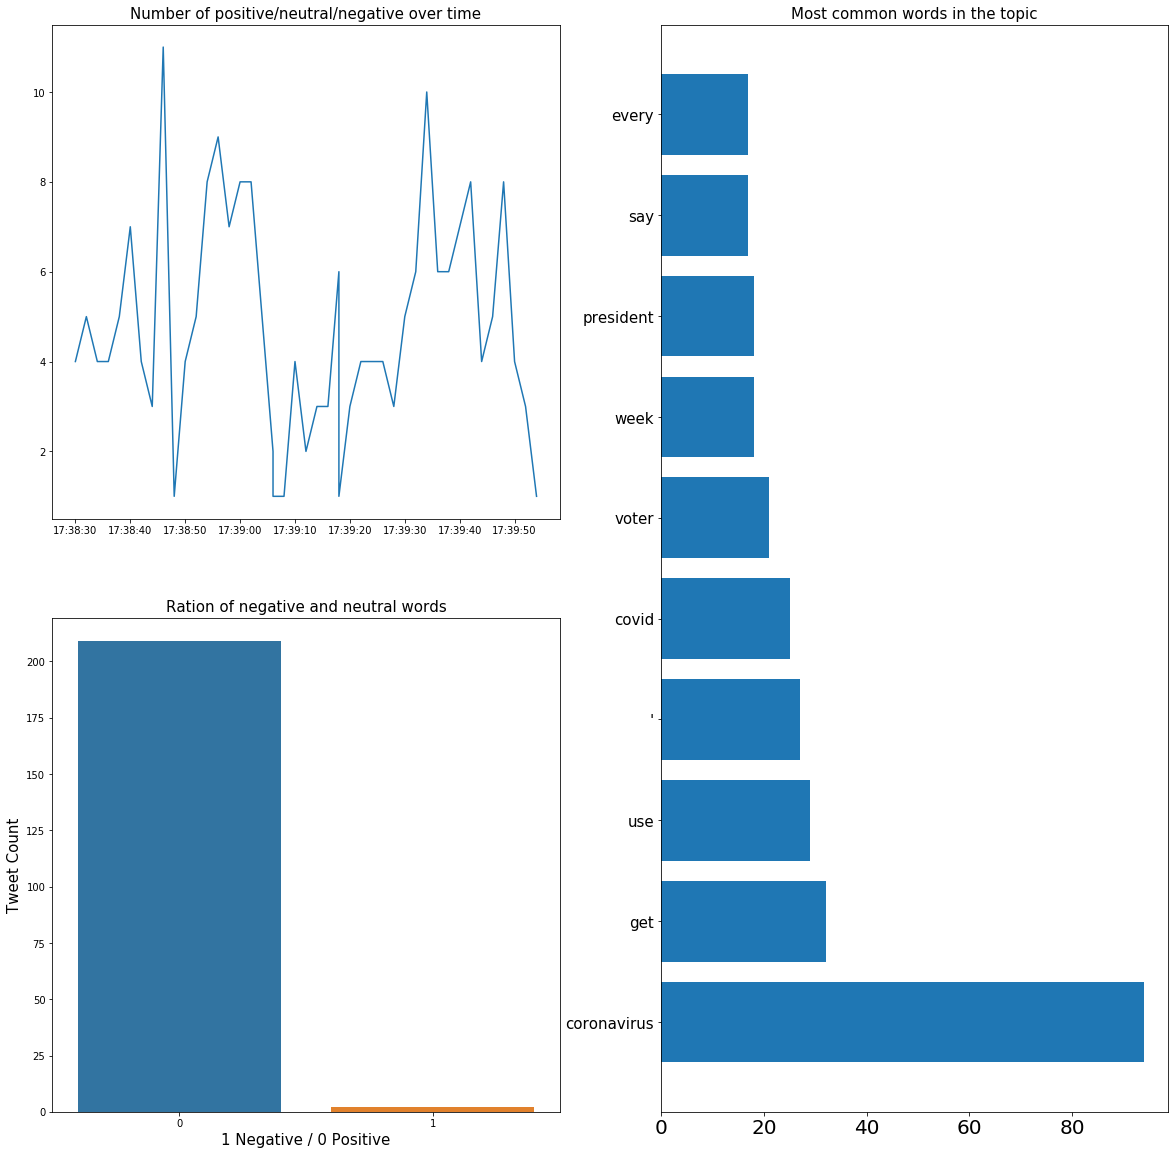

In [70]:
# fig, axes = plt.subplots(2,2, figsize = (20,20))


# ax1 = plt.subplot(221)
# plt.title('Number of positive/neutral/negative over time', fontsize = 15)

# ax1 = plt.plot(result['Time'], (result["Num of 'Coronavirus' mentions"]))
# # ax1 = plt.plot(result['created_at'], (result['predictions']==1))

# ax2 = plt.subplot(122)
# plt.title('Most common words in the topic', fontsize = 15)
# plt.xticks(fontsize= 20)
# plt.yticks(fontsize = 15)
# ax2 = plt.barh(counts['token'], counts['token_count'])

# ax3 = plt.subplot(223)
# plt.title('Ration of negative and neutral words', fontsize = 15)
# plt.xlabel('1 Negative / 0 Positive', fontsize = 15)
# plt.ylabel('Tweet Count', fontsize = 15)
# predictions = df['predictions'].value_counts()
# sns.barplot(predictions.index, predictions.values)

# plt.show()


In [71]:
# df_negative = df.loc[df['predictions']==1]


In [72]:


# st.markdown("### 🎲 The Application")

# st.markdown("* This gives a general overview of the data including"
#             "frequency of games over time, most games played in a day, and longest break"
#             "between games.")

In [73]:

# print("Last update =", datetime.now())

Last update = 2020-05-24 18:42:02.800563


In [74]:
# st.markdown("This application is a Streamlit dashboard hosted on Heroku that can be used"
#             "to explore the results from board game matches that I tracked over the last year.")

In [75]:
# st.markdown("** Overview **")

In [76]:
# st.pyplot(fig)

In [77]:
# st.markdown("* Also below there's a list of the Tweets that are 90%+ likley to be offensive.")

In [78]:
# st.write(df_negative['text'])